### Creating the label .txt files

In [ ]:
## Run this code to make new labels

import os

# Define the path to the directory containing the images
data_dir = "../data/images_original"

# Initialize empty lists to store training and testing labels
train_labels_list = []
test_labels_list = []

# Iterate through each subdirectory (genre folder) in the data directory
for genre_folder in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre_folder)
    if os.path.isdir(genre_path):
        # Get a list of all image files in the genre folder
        image_files = sorted(os.listdir(genre_path))
        # Use all but the last 20 images for training
        train_images = image_files[:-20]
        # Use the last 20 images for testing
        test_images = image_files[-20:]
        # Append the training labels to train_labels_list
        for image_file in train_images:
            train_labels_list.append(f"{os.path.join(genre_folder, image_file)} {genre_folder}")
        # Append the testing labels to test_labels_list
        for image_file in test_images:
            test_labels_list.append(f"{os.path.join(genre_folder, image_file)} {genre_folder}")

# Save the training labels to a text file
with open("train_labels.txt", "w") as f:
    for item in train_labels_list:
        f.write("%s\n" % item)

# Save the testing labels to a text file
with open("test_labels.txt", "w") as f:
    for item in test_labels_list:
        f.write("%s\n" % item)


### Creating the generators

In [24]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import os

In [25]:
# Define the paths
train_images_dir = "../data/images_original"
train_labels_path = "train_labels.txt"
test_labels_path = "test_labels.txt"

# Load training labels from the 'train_labels.txt' file
train_labels = pd.read_csv(train_labels_path, header=None, delimiter=" ", names=['ID', 'target'])

# Add the directory to the filename
train_labels['ID'] = train_labels['ID'].apply(lambda x: os.path.join(train_images_dir, x))

# Initialize the ImageDataGenerator for training
datagen_train = ImageDataGenerator(rescale=1./255)

# Create the training generator
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_labels,
    directory=None,
    x_col='ID',
    y_col='target',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load testing labels from the 'test_labels.txt' file
test_labels = pd.read_csv(test_labels_path, header=None, delimiter=" ", names=['ID', 'target'])

# Add the directory to the filename
test_labels['ID'] = test_labels['ID'].apply(lambda x: os.path.join(train_images_dir, x))

# Initialize the ImageDataGenerator for testing
datagen_test = ImageDataGenerator(rescale=1./255)

# Create the testing generator
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_labels,
    directory=None,
    x_col='ID',
    y_col='target',
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


### Model Building

In [29]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import numpy as np
import tensorflow as tf
from keras import layers, models
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
from keras.callbacks import EarlyStopping # for better training
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU

In [30]:

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

## This was my best Model (Abotut 46% Val Accuracy):

Although the early stopping didn't work for some reason when I tried to run it

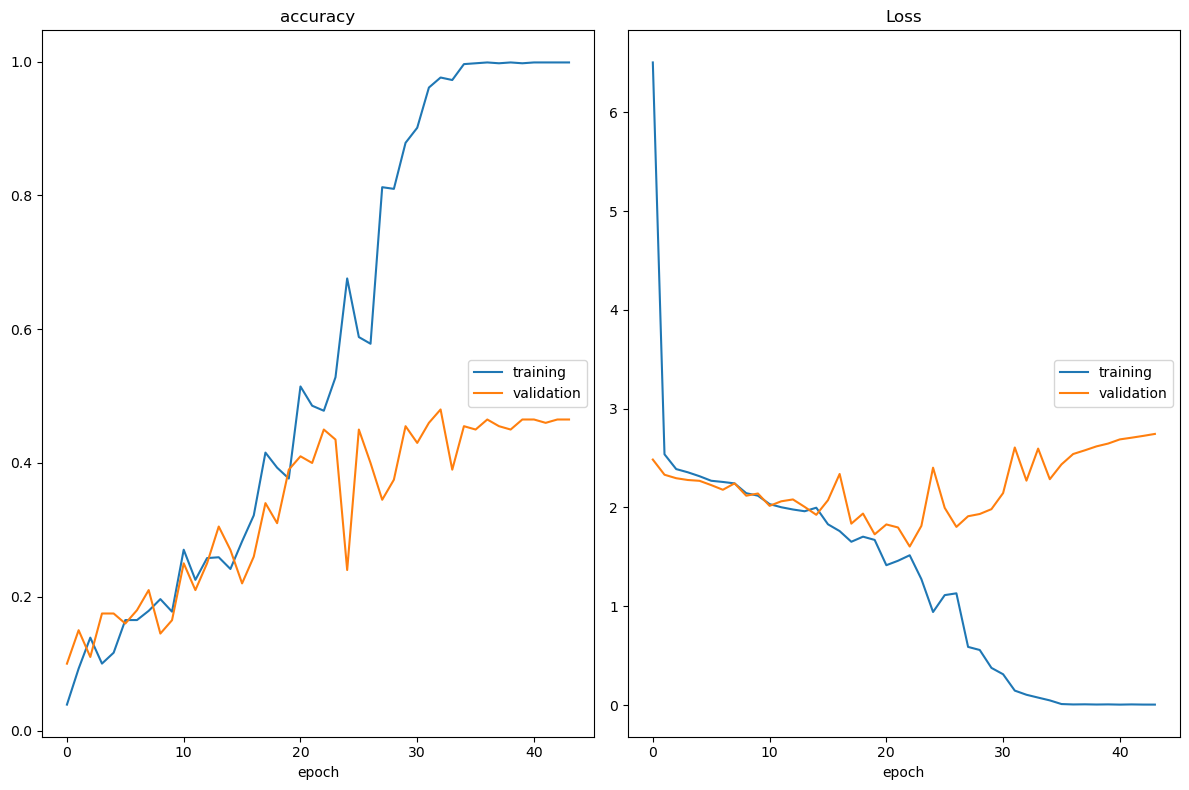

accuracy
	training         	 (min:    0.039, max:    0.999, cur:    0.999)
	validation       	 (min:    0.100, max:    0.480, cur:    0.465)
Loss
	training         	 (min:    0.005, max:    6.505, cur:    0.005)
	validation       	 (min:    1.605, max:    2.745, cur:    2.745)
25/25 [==============================] - 36s 1s/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 2.7446 - val_accuracy: 0.4650
Epoch 45/70
17/25 [===================>..........] - ETA: 10s - loss: 0.0065 - accuracy: 0.9982 

KeyboardInterrupt: 

In [7]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(256, 256, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))
cnn_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(10, activation='softmax'))  # Assuming there are 10 genres


cnn_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Train the model using the training generator
cnn_model.fit(train_generator, epochs=70, validation_data=test_generator, callbacks = [PlotLossesKeras()])



-----

#### None of the other Models I tried below helped any

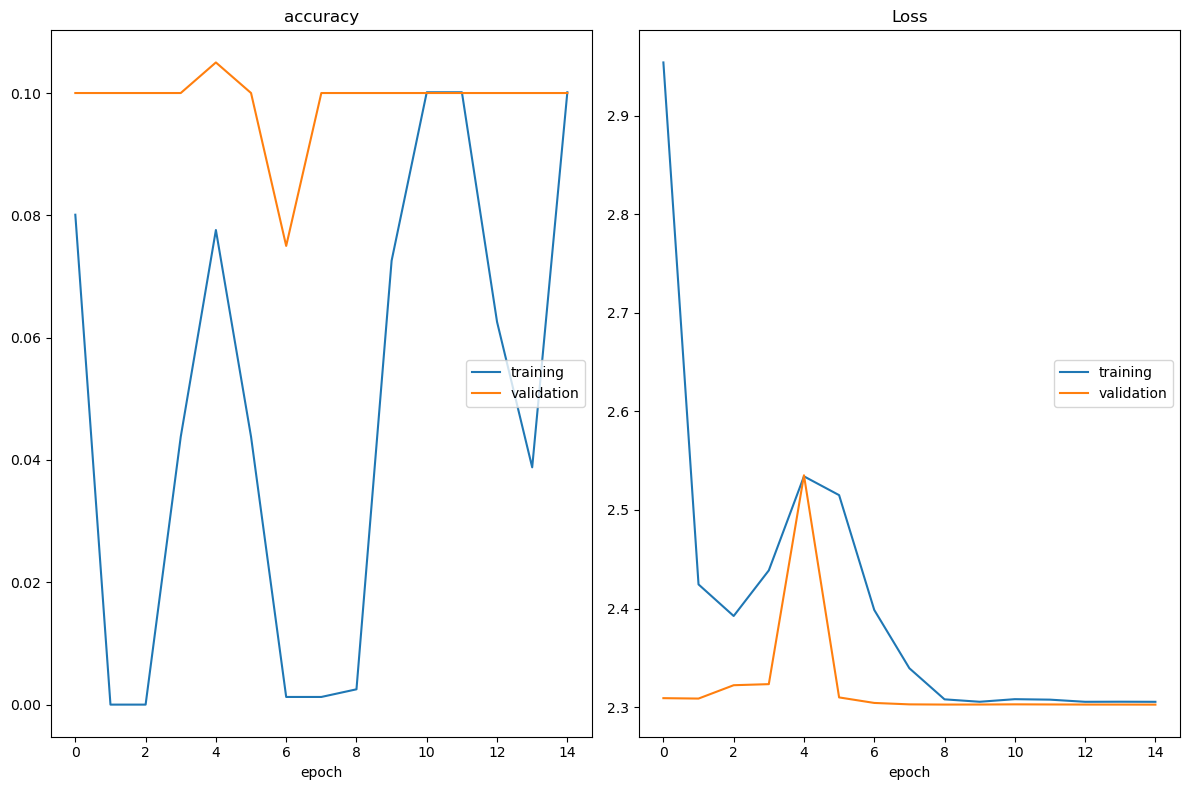

accuracy
	training         	 (min:    0.000, max:    0.100, cur:    0.100)
	validation       	 (min:    0.075, max:    0.105, cur:    0.100)
Loss
	training         	 (min:    2.305, max:    2.954, cur:    2.305)
	validation       	 (min:    2.303, max:    2.535, cur:    2.303)
25/25 [==============================] - 65s 3s/step - loss: 2.3054 - accuracy: 0.1001 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 16/70


KeyboardInterrupt: 

In [32]:
# Define the CNN model
cnn_model = Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(256, 256, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))

cnn_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

cnn_model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

cnn_model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

cnn_model.add(Conv2D(512, (3, 3), activation='linear', padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Flatten())

cnn_model.add(Dense(1024, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(512, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(10, activation='softmax'))  # Assuming there are 10 genres


cnn_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Train the model using the training generator
cnn_model.fit(train_generator, epochs=70, validation_data=test_generator, callbacks = [earlyStopping, PlotLossesKeras()])



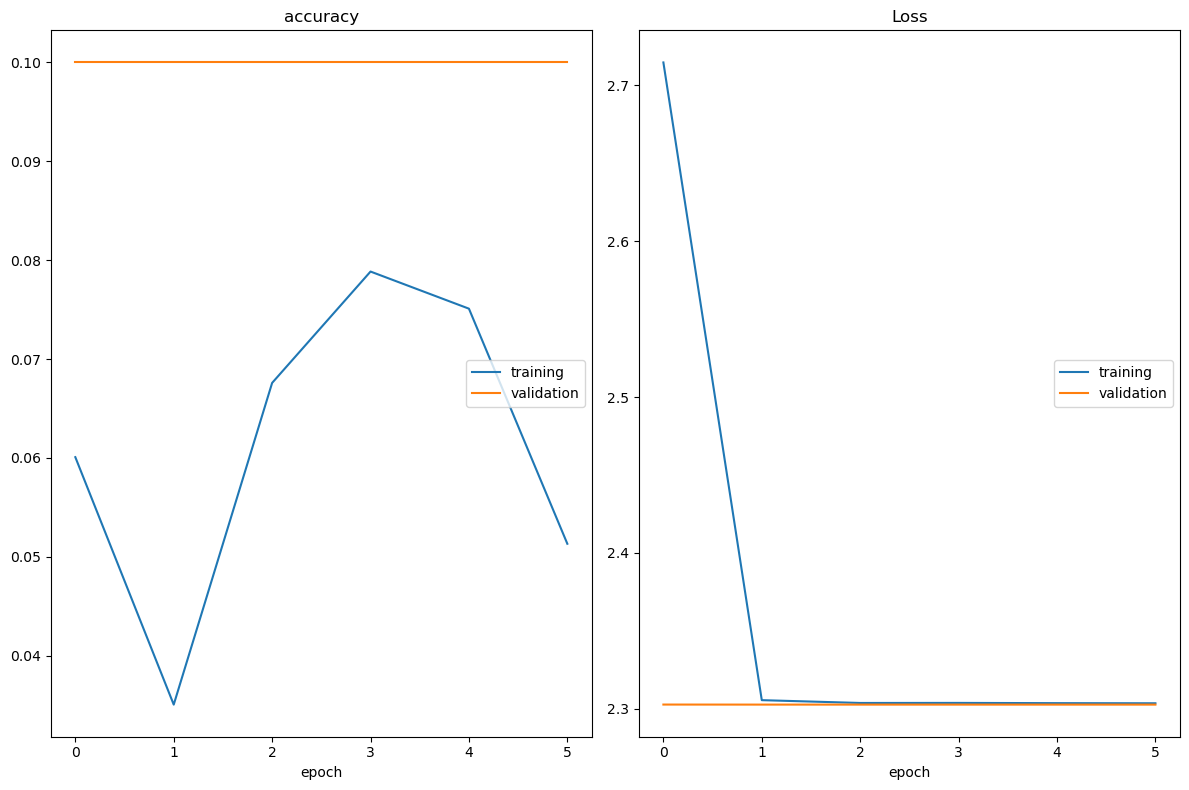

accuracy
	training         	 (min:    0.035, max:    0.079, cur:    0.051)
	validation       	 (min:    0.100, max:    0.100, cur:    0.100)
Loss
	training         	 (min:    2.303, max:    2.715, cur:    2.303)
	validation       	 (min:    2.303, max:    2.303, cur:    2.303)
25/25 [==============================] - 66s 3s/step - loss: 2.3035 - accuracy: 0.0513 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/70
25/25 [==============================] - ETA: 0s - loss: 2.3034 - accuracy: 0.0588

KeyboardInterrupt: 

In [33]:
from keras.optimizers import Adam
# Define the CNN model
balanced_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.5),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(10, activation='softmax')  # Assuming there are 10 genres
])

# Compile the model
optimizer = Adam(lr=0.0001)  # Adjust the learning rate
balanced_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the training generator
balanced_model.fit(train_generator, epochs=70, validation_data=test_generator, callbacks=[earlyStopping, PlotLossesKeras()])
